In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


<h3>This notebook pertains to a project done for a Big Data Analytics course</h3>
<p>
The main research questions that this project attempts to answer are: 

<p>How does the Stockholm housing market for apartments compare with AirBnB rentals? <p> - Do they have strong associations in any meaningful way and if so, can we uncover some of them?<p> - Additionally, the project also attempts to find features within the housing listings on Hemnet (Sweden's largest housing listing site) to build an apartment pricing predictor with an accuracy > 90%
<p>

Our main data sources are:
 - InsideAirBnB
 - Hemnet listings


In [1]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import time

In [ ]:
#################
# DATA COLLECTION
#################

# For AirBnB data, we used the open dataset available at http://insideairbnb.com/stockholm/
# For Stockholm's housing data:
# We created a fork (https://github.com/aeganskies/HemKop-SV)
# of https://github.com/gustafvh/Apartment-ML-Predictor-Stockholm_-with-WebScraper-and-Data-Insights
# to scrape real estate listings from www.hemnet.se
# since the original repository was broken (older than 3 years) & was not updated with changes made to
# Hemnet's website, changes in selenium packages & other needed refactorings to save the scraped data temporarily
# in the case of system crashes or network outages (Total scraping time > 90 hours!)
# These changes were made mostly in the Webscraper component, besides some changes for Geocoding the location
# of the apartment listings

%run main.py #DO NOT RUN THIS ON A WHIM! -> takes 90+ hours to scrape the data!!


In [ ]:
################
# PRE-PROCESSING
################

# Load the raw csv file
df = pd.read_csv('/Data/RawDataFile.csv')

# convert float64 datatypes to int64
df['Date'] = df['Date'].astype(np.int64)
df['Rooms'] = df['Rooms'].astype(np.int64)
df['Rent'] = df['Rent'].astype(np.int64)
df['Price'] = df['Price'].astype(np.int64)

# create new Datetime column
df['Datetime'] = pd.to_datetime(df['Date'].astype(str), format='%Y%m%d')

# clean up broker/realtor names (remove the '\n')
df.Broker = [broker.replace('\n', ' ') for broker in df.Broker]

# remove duplicates
df.drop_duplicates(subset=['Adress'], keep='last', inplace=True)

# Add Price/square meter column (PricePerKvm)
df['PricePerKvm'] = 0.0

for i in range(0, len(df)):
        df.at[i, 'PricePerKvm'] = round(df.at[i, 'Price'] / df.at[i, 'Size'], 0)

df['PricePerKvm'] = df['PricePerKvm'].astype('float')

# Save Cleaned data
df.to_csv('./Data/CleanDataFile.csv', index=False)

In [ ]:
# Add Geocoding -> this is rate limited to 5000 API calls per day.
# Enter your own API key in a config.py file in the following format
# yelp_api_key = "MY_SECRET_KEY"

from YelpApi import updateDfWithYelpDetails

# Read CSV and add Geocoding via Yelp API
df = pd.read_csv('/Data/CleanDataFile.csv')
df = updateDfWithYelpDetails(apData, 0, len(apData))
df.to_csv('./Data/CleanHnetData.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16700 entries, 0 to 16699
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         16700 non-null  int64  
 1   Adress       16700 non-null  object 
 2   Size         16700 non-null  float64
 3   Rooms        16700 non-null  int64  
 4   Broker       16700 non-null  object 
 5   Rent         16700 non-null  int64  
 6   Price        16700 non-null  int64  
 7   NearbyPOIs   16700 non-null  int64  
 8   Latitude     16700 non-null  float64
 9   Longitude    16700 non-null  float64
 10  PricePerKvm  16700 non-null  float64
dtypes: float64(4), int64(5), object(2)
memory usage: 1.4+ MB


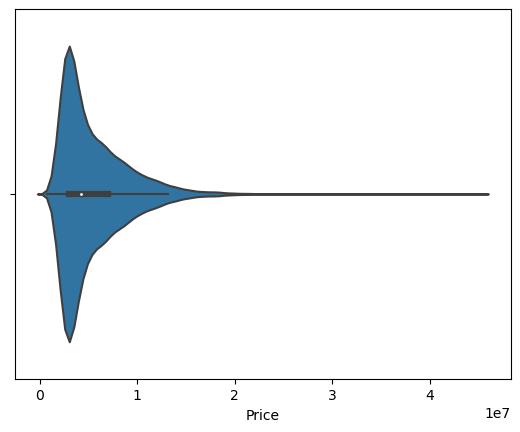

In [4]:
##################
# DATA EXPLORATION
##################

df = pd.read_csv('./Data/CleanHnetData.csv')

df.info()
df.describe()

# Check density & distribution via violin plot
sb.violinplot(data=df, x='Price')

# Remove large outliers for Rent & Price that skew the data
quant_rent = df['Rent'].quantile(0.8)
df = df[df['Rent'] < quant_rent]
df = df[df['Rent'] > 0]

quant_price = df['Price'].quantile(0.8)
df = df[df['Price'] < quant_price]
df = df[df['Price'] > 0]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10670 entries, 3952 to 16699
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         10670 non-null  int64  
 1   Adress       10670 non-null  object 
 2   Size         10670 non-null  float64
 3   Rooms        10670 non-null  int64  
 4   Broker       10670 non-null  object 
 5   Rent         10670 non-null  int64  
 6   Price        10670 non-null  int64  
 7   NearbyPOIs   10670 non-null  int64  
 8   Latitude     10670 non-null  float64
 9   Longitude    10670 non-null  float64
 10  PricePerKvm  10670 non-null  float64
dtypes: float64(4), int64(5), object(2)
memory usage: 1000.3+ KB


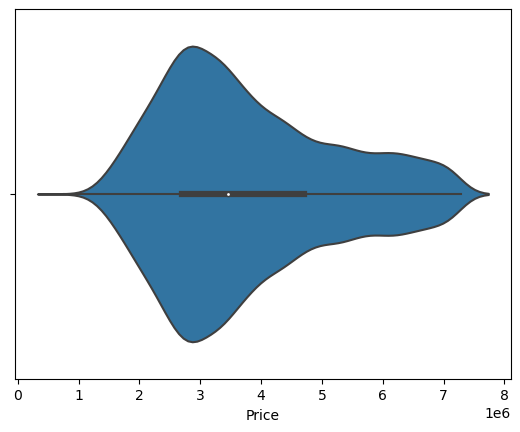

In [5]:
# Check violin plot after removing large outliers
sb.violinplot(data=df, x='Price')

df.info()

# Save normalized data file
df.to_csv('./Data/NormDataFile.csv', index=False)

In [12]:
##################
# PREDICTION MODEL
##################

# Build prediction mode using Random Forest Regression

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from Model import getPredictions
from ModelEvaluation import tryParameters
from Accuracy import printMeanAbsoluteError, printMeanAbsolutePercentageError
from VisualizeData import featureImportance, featuresCorrelation
import warnings
warnings.simplefilter('ignore', FutureWarning)
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display, HTML

df = pd.read_csv('./Data/NormDataFile.csv')

featuresToTrainOn = ['Rooms', 'Size', 'NearbyPOIs', 'Latitude', 'Longitude']
target = 'Price'

# # # # Predictions is array with predictions
predictions, valPredictionTarget, model = getPredictions(
    df, featuresToTrainOn, target)

print(df.info())
display(HTML(df.head().to_html()))

printMeanAbsoluteError(predictions, valPredictionTarget)
printMeanAbsolutePercentageError(predictions, valPredictionTarget)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10670 entries, 0 to 10669
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         10670 non-null  int64  
 1   Adress       10670 non-null  object 
 2   Size         10670 non-null  float64
 3   Rooms        10670 non-null  int64  
 4   Broker       10670 non-null  object 
 5   Rent         10670 non-null  int64  
 6   Price        10670 non-null  int64  
 7   NearbyPOIs   10670 non-null  int64  
 8   Latitude     10670 non-null  float64
 9   Longitude    10670 non-null  float64
 10  PricePerKvm  10670 non-null  float64
dtypes: float64(4), int64(5), object(2)
memory usage: 917.1+ KB
None


,Date,Adress,Size,Rooms,Broker,Rent,Price,NearbyPOIs,Latitude,Longitude,PricePerKvm
0,20211116,Hälsingegatan 6,63.0,2,Unknown,1938,7290000,822,59.343654,18.041611,115714.0
1,2014061,Hökens Gata 7,112.0,3,Unknown,4939,7280000,1500,59.318086,18.073196,65000.0
2,20220329,Henriksdalsallén 24B,83.0,3,Sara Wennertorp,4249,7280000,168,59.310727,18.104095,87711.0
3,20220312,Sjöviksvägen 59,80.5,3,Kristoffer Pettersson,4375,7275000,189,59.306522,18.031998,90373.0
4,20221118,Tideliusgränd 11,80.0,3,Hampus Schöllin,4195,7275000,907,59.311428,18.064957,90938.0


Predictions for 2668 apartments are off (MAE) by:
349,609.00 SEK
Predictions for 2668 apartments are off (MAPE) by:
9.15 %
